In [ ]:
!pip install kaggle
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset
!unzip -q real-life-violence-situations-dataset.zip -d /content/RLVSD

print("Dataset downloaded to local Colab storage")
print("Note: Will be deleted when runtime ends")
print("We'll save final model to Drive later")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset
License(s): copyright-authors
 99% 3.56G/3.58G [00:58<00:00, 41.8MB/s]
100% 3.58G/3.58G [00:58<00:00, 66.3MB/s]
Dataset downloaded to local Colab storage
Note: Will be deleted when runtime ends
We'll save final model to Drive later


In [ ]:
!ls "/content/RLVSD/real life violence situations/Real Life Violence Dataset"


NonViolence  Violence


In [ ]:
# ============================
# SINGLE-CELL STAGED TRAINING
# ============================

import os, cv2, gc
import numpy as np
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ----------------------------
# CONFIG
# ----------------------------
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
DATASET_DIR = "/content/RLVSD/real life violence situations/Real Life Violence Dataset"
CLASSES_LIST = ["NonViolence", "Violence"]

BATCH_SIZE = 4
EPOCHS_PER_STAGE = 30

print("✅ Setup complete")

# ----------------------------
# FRAME EXTRACTION
# ----------------------------
def frames_extraction(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(total // SEQUENCE_LENGTH, 1)

    for i in range(SEQUENCE_LENGTH):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frames.append(frame / 255.0)

    cap.release()
    return frames

# ----------------------------
# DATASET LOADER (STAGED)
# ----------------------------
def create_dataset(start=0, limit=400):
    X, y = [], []
    for idx, cls in enumerate(CLASSES_LIST):
        cls_path = os.path.join(DATASET_DIR, cls)
        files = sorted(os.listdir(cls_path))[start:start+limit]

        print(f"\nLoading {cls}: {start} → {start+limit}")
        for f in tqdm(files):
            frames = frames_extraction(os.path.join(cls_path, f))
            if len(frames) == SEQUENCE_LENGTH:
                X.append(frames)
                y.append(idx)
    return np.array(X), np.array(y)

# ----------------------------
# BUILD MODEL
# ----------------------------
mobilenet = MobileNetV2(include_top=False, weights="imagenet")
mobilenet.trainable = True
for layer in mobilenet.layers[:-40]:
    layer.trainable = False

model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    TimeDistributed(mobilenet),
    TimeDistributed(Flatten()),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("✅ Model built")

# ----------------------------
# CALLBACKS
# ----------------------------
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/content/best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=7,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    verbose=1
)

# ----------------------------
# STAGED TRAINING
# ----------------------------
STAGES = [(0,400), (400,400), (800,200)]

for stage, (start, limit) in enumerate(STAGES, 1):
    print(f"\n==============================")
    print(f"🚀 STAGE {stage}: videos {start} → {start+limit}")
    print(f"==============================")

    X, y = create_dataset(start, limit)
    y = to_categorical(y, num_classes=2)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, shuffle=True, random_state=42
    )

    model.fit(
        X_train, y_train,
        epochs=EPOCHS_PER_STAGE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1
    )

    # clean RAM
    del X, y, X_train, X_test, y_train, y_test
    gc.collect()

    model.save(f"/content/stage_{stage}_model.keras")
    print(f"✅ Stage {stage} model saved")

# ----------------------------
# FINAL SAVE
# ----------------------------
model.save("/content/final_violence_model.keras")
print("\n TRAINING COMPLETE")
print("Final model saved as /content/final_violence_model.keras")

print("\nDownload with:")
print("from google.colab import files")
print("files.download('/content/final_violence_model.keras')")


✅ Setup complete


/tmp/ipython-input-2361032744.py:68: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model built

🚀 STAGE 1: videos 0 → 400

Loading NonViolence: 0 → 400


100%|██████████| 400/400 [05:07<00:00,  1.30it/s]



Loading Violence: 0 → 400


100%|██████████| 400/400 [12:41<00:00,  1.90s/it]


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.4824 - loss: 0.7776
Epoch 1: val_accuracy improved from -inf to 0.61806, saving model to /content/best_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 135s 310ms/step - accuracy: 0.4829 - loss: 0.7772 - val_accuracy: 0.6181 - val_loss: 0.6546 - learning_rate: 1.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5874 - loss: 0.6545
Epoch 2: val_accuracy improved from 0.61806 to 0.68750, saving model to /content/best_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.5874 - loss: 0.6546 - val_accuracy: 0.6875 - val_loss: 0.6001 - learning_rate: 1.0000e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6363 - loss: 0.6377
Epoch 3: val_accuracy improved from 0.68750 to 0.78472, saving model to /content/best_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.6364 - loss: 0.6376 - val_accuracy: 0.7847 - val_loss: 0.5584 - learning_rate: 1.0000e-04


100%|██████████| 400/400 [00:59<00:00,  6.74it/s]



Loading Violence: 400 → 800


100%|██████████| 400/400 [06:28<00:00,  1.03it/s]


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6294 - loss: 0.8224
Epoch 1: val_accuracy did not improve from 0.92361
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.6298 - loss: 0.8216 - val_accuracy: 0.7292 - val_loss: 0.6359 - learning_rate: 5.0000e-05
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7899 - loss: 0.4687
Epoch 2: val_accuracy did not improve from 0.92361
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.7899 - loss: 0.4688 - val_accuracy: 0.7917 - val_loss: 0.5248 - learning_rate: 5.0000e-05
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8074 - loss: 0.4784
Epoch 3: val_accuracy did not improve from 0.92361
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.8074 - loss: 0.4781 - val_accuracy: 0.7778 - val_loss: 0.5061 - learning_rate: 5.0000e-05
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8131 - loss: 0.3882
Epoch 4: val_accuracy did not improve from 0.92361


100%|██████████| 200/200 [02:08<00:00,  1.55it/s]



Loading Violence: 800 → 1000


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7447 - loss: 0.6577
Epoch 1: val_accuracy did not improve from 0.92361
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.7449 - loss: 0.6580 - val_accuracy: 0.8472 - val_loss: 0.4270 - learning_rate: 1.2500e-05
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8321 - loss: 0.5385
Epoch 2: val_accuracy did not improve from 0.92361
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.8325 - loss: 0.5375 - val_accuracy: 0.8472 - val_loss: 0.3957 - learning_rate: 1.2500e-05
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8229 - loss: 0.5366
Epoch 3: val_accuracy did not improve from 0.92361
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.8228 - loss: 0.5356 - val_accuracy: 0.8611 - val_loss: 0.3758 - learning_rate: 1.2500e-05
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8836 - loss: 0.3661
Epoch 4: val_accuracy did not improve from 0.92361
72/72 ━━━━━━━━

In [ ]:
# ============================
# SINGLE-CELL EVALUATION + FPR (FIXED)
# ============================

import os, cv2, gc
import numpy as np
from keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------------
# CONFIG
# ----------------------------
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
DATASET_DIR = "/content/RLVSD/real life violence situations/Real Life Violence Dataset"
CLASSES_LIST = ["NonViolence", "Violence"]

# ----------------------------
# FRAME EXTRACTION
# ----------------------------
def frames_extraction(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(total // SEQUENCE_LENGTH, 1)

    for i in range(SEQUENCE_LENGTH):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frames.append(frame / 255.0)

    cap.release()
    return frames

# ----------------------------
# DATASET LOADER
# ----------------------------
def create_dataset(start=0, limit=200):
    X, y = [], []
    for idx, cls in enumerate(CLASSES_LIST):
        cls_path = os.path.join(DATASET_DIR, cls)
        files = sorted(os.listdir(cls_path))[start:start+limit]

        for f in files:
            frames = frames_extraction(os.path.join(cls_path, f))
            if len(frames) == SEQUENCE_LENGTH:
                X.append(frames)
                y.append(idx)
    return np.array(X), np.array(y)

# ----------------------------
# LOAD MODEL
# ----------------------------
model = load_model("/content/final_violence_model.keras")
print("Model loaded")

# ----------------------------
# RECREATE TEST SET
# ----------------------------
X, y = create_dataset(start=800, limit=200)
y = to_categorical(y, num_classes=2)

_, X_test, _, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Test set shape:", X_test.shape)

# ----------------------------
# EVALUATE MODEL
# ----------------------------
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("\n============================")
print("EVALUATION RESULTS")
print("============================")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# ----------------------------
# PREDICTIONS
# ----------------------------
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)
tn, fp, fn, tp = cm.ravel()

# ----------------------------
# METRICS
# ----------------------------
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
fpr = fp / (fp + tn)

print("\nDetailed Metrics:")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print(f"False Positive Rate: {fpr*100:.2f}%")

# ----------------------------
# REPORT
# ----------------------------
print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=["NonViolence", "Violence"],
    digits=4
))

# ----------------------------
# CLEANUP
# ----------------------------
del X, y, X_test, y_test, y_pred
gc.collect()

print("\nEvaluation complete")


Model loaded
Test set shape: (80, 16, 64, 64, 3)

EVALUATION RESULTS
Test Accuracy: 95.00%

Detailed Metrics:
Precision: 97.06%
Recall: 91.67%
F1 Score: 94.29%
False Positive Rate: 2.27%

Classification Report:
              precision    recall  f1-score   support

 NonViolence     0.9348    0.9773    0.9556        44
    Violence     0.9706    0.9167    0.9429        36

    accuracy                         0.9500        80
   macro avg     0.9527    0.9470    0.9492        80
weighted avg     0.9509    0.9500    0.9498        80


Evaluation complete


In [ ]:
from google.colab import files

files.download('/content/final_violence_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

files.download('/content/best_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Test on videos from your training dataset
import os

# Path to your original dataset
dataset_path = "/content/RLVSD/real life violence situations/Real Life Violence Dataset"

# Test on actual violence videos
violence_videos = os.listdir(f"{dataset_path}/Violence")[:5]
non_violence_videos = os.listdir(f"{dataset_path}/NonViolence")[:5]

print("🧪 TESTING ON TRAINING DATASET VIDEOS:\n")

print("Violence videos:")
for vid in violence_videos:
    video_path = f"{dataset_path}/Violence/{vid}"
    frames = frames_extraction(video_path)
    if len(frames) == 16:
        pred = model.predict(np.array([frames]), verbose=0)
        violence = pred[0][1] * 100
        print(f"  {vid}: {violence:.1f}% violence - {'⚠️ UNSAFE' if violence > 50 else '✅ SAFE'}")

print("\nNon-Violence videos:")
for vid in non_violence_videos:
    video_path = f"{dataset_path}/NonViolence/{vid}"
    frames = frames_extraction(video_path)
    if len(frames) == 16:
        pred = model.predict(np.array([frames]), verbose=0)
        violence = pred[0][1] * 100
        print(f"  {vid}: {violence:.1f}% violence - {'⚠️ UNSAFE' if violence > 50 else '✅ SAFE'}")

🧪 TESTING ON TRAINING DATASET VIDEOS:

Violence videos:
  V_547.mp4: 88.2% violence - ⚠️ UNSAFE
  V_541.mp4: 80.9% violence - ⚠️ UNSAFE
  V_352.mp4: 97.7% violence - ⚠️ UNSAFE
  V_838.mp4: 98.8% violence - ⚠️ UNSAFE
  V_463.mp4: 98.4% violence - ⚠️ UNSAFE

Non-Violence videos:
  NV_299.mp4: 1.0% violence - ✅ SAFE
  NV_33.mp4: 0.3% violence - ✅ SAFE
  NV_714.mp4: 1.1% violence - ✅ SAFE
  NV_363.mp4: 39.2% violence - ✅ SAFE
  NV_170.mp4: 36.9% violence - ✅ SAFE


In [ ]:
# ============================
# MINIMAL THRESHOLD SELECTION
# ============================

import os, cv2
import numpy as np
from keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

# ----------------------------
# CONFIG
# ----------------------------
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
DATASET_DIR = "/content/RLVSD/real life violence situations/Real Life Violence Dataset"
CLASSES_LIST = ["NonViolence", "Violence"]
MAX_FPR = 0.07

# ----------------------------
# FRAME EXTRACTION
# ----------------------------
def frames_extraction(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(total // SEQUENCE_LENGTH, 1)

    for i in range(SEQUENCE_LENGTH):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frames.append(frame / 255.0)

    cap.release()
    return frames

# ----------------------------
# LOAD SMALL VALIDATION SET
# ----------------------------
def load_small_val(start=800, limit=30):  # 60 videos total
    X, y = [], []
    for idx, cls in enumerate(CLASSES_LIST):
        cls_path = os.path.join(DATASET_DIR, cls)
        files = sorted(os.listdir(cls_path))[start:start+limit]

        for f in files:
            frames = frames_extraction(os.path.join(cls_path, f))
            if len(frames) == SEQUENCE_LENGTH:
                X.append(frames)
                y.append(idx)
    return np.array(X), np.array(y)

# ----------------------------
# LOAD MODEL & DATA
# ----------------------------
model = load_model("/content/final_violence_model.keras")
X, y = load_small_val()
y = to_categorical(y, 2)

# ----------------------------
# PREDICT
# ----------------------------
y_pred = model.predict(X, verbose=0)
scores = y_pred[:, 1]
labels = np.argmax(y, axis=1)

# ----------------------------
# THRESHOLD SWEEP
# ----------------------------
best_t, best_re = 0, 0

for t in np.linspace(0, 1, 101):
    preds = (scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)

    if fpr <= MAX_FPR and recall > best_re:
        best_t, best_re = t, recall

print("\nFINAL THRESHOLD")
print("================")
print(f"Threshold: {best_t:.2f}")
print(f"Recall: {best_re*100:.2f}%")



FINAL THRESHOLD
Threshold: 0.46
Recall: 93.33%


Loading model...
Model loaded


COMPREHENSIVE VIOLENCE DETECTION TEST

COMPREHENSIVE ANALYSIS: V_838.mp4

STAGE 1: Quick Scan (Frame-by-Frame)
Overall: 97.3% - UNSAFE
Violent Moments: 6

STAGE 2: Contextual Analysis (16-Frame Sequence)
Overall: 98.8% - UNSAFE

FINAL VERDICT
Quick Scan: 97.3% - UNSAFE
Contextual: 98.8% - UNSAFE

FINAL: UNSAFE
Confidence: HIGH
Reasoning: Both methods agree

Violent Timestamps:
• 0:00:00 (96.3%)
• 0:00:01 (98.4%)
• 0:00:02 (98.0%)
• 0:00:03 (97.2%)
• 0:00:04 (99.3%)
... and 1 more

Timeline saved: /content/RLVSD/real life violence situations/Real Life Violence Dataset/Violence/V_838_comprehensive_timeline.png


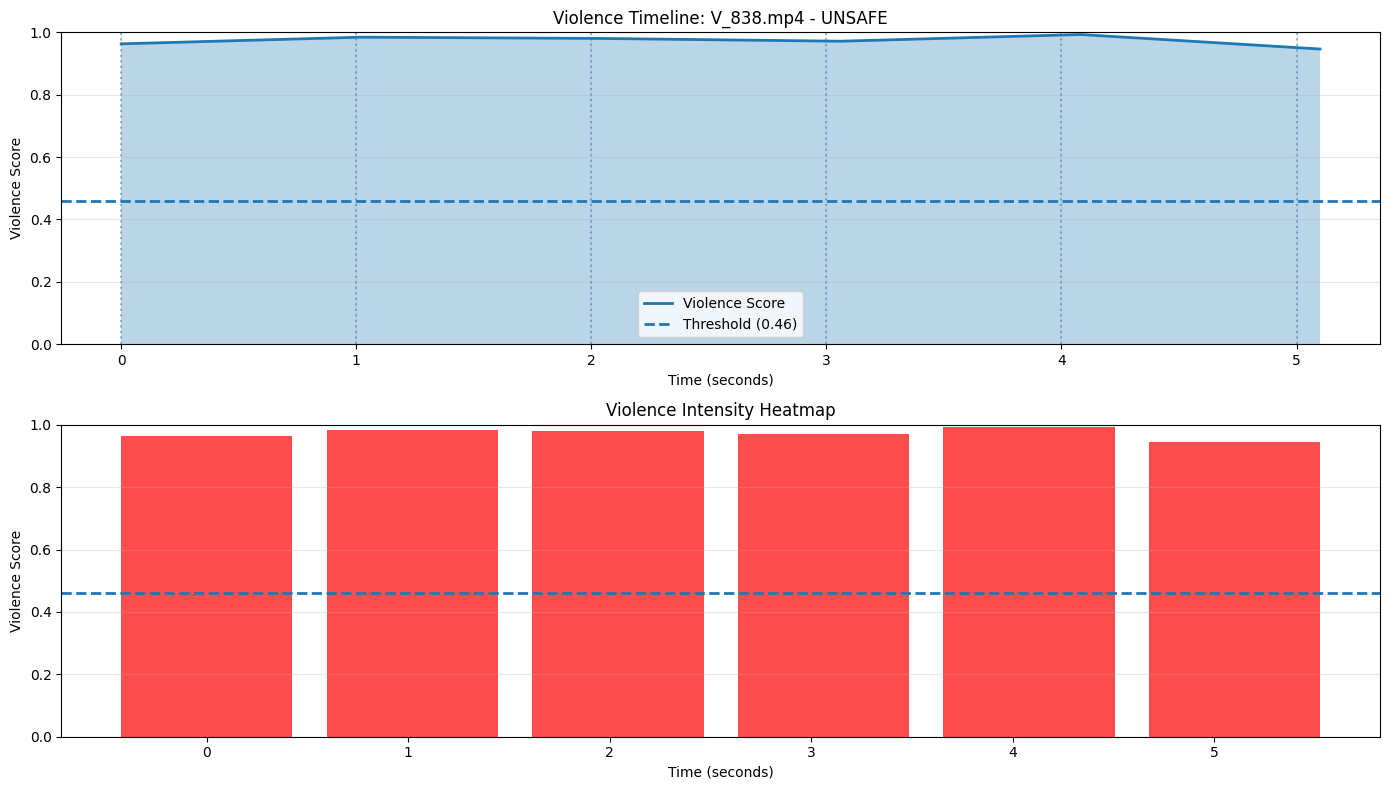

Results exported to: comprehensive_detection_results.json
COMPREHENSIVE ANALYSIS: NV_363.mp4

STAGE 1: Quick Scan (Frame-by-Frame)
Overall: 60.4% - UNSAFE
Violent Moments: 7

STAGE 2: Contextual Analysis (16-Frame Sequence)
Overall: 40.8% - SAFE

FINAL VERDICT
Quick Scan: 60.4% - UNSAFE
Contextual: 40.8% - SAFE

FINAL: SAFE
Confidence: MEDIUM
Reasoning: Contextual analysis shows sports/action scene, not actual violence

Violent Timestamps:
• 0:00:00 (91.3%)
• 0:00:01 (46.9%)
• 0:00:02 (97.4%)
• 0:00:03 (95.6%)
• 0:00:04 (98.9%)
... and 2 more

Timeline saved: /content/RLVSD/real life violence situations/Real Life Violence Dataset/NonViolence/NV_363_comprehensive_timeline.png


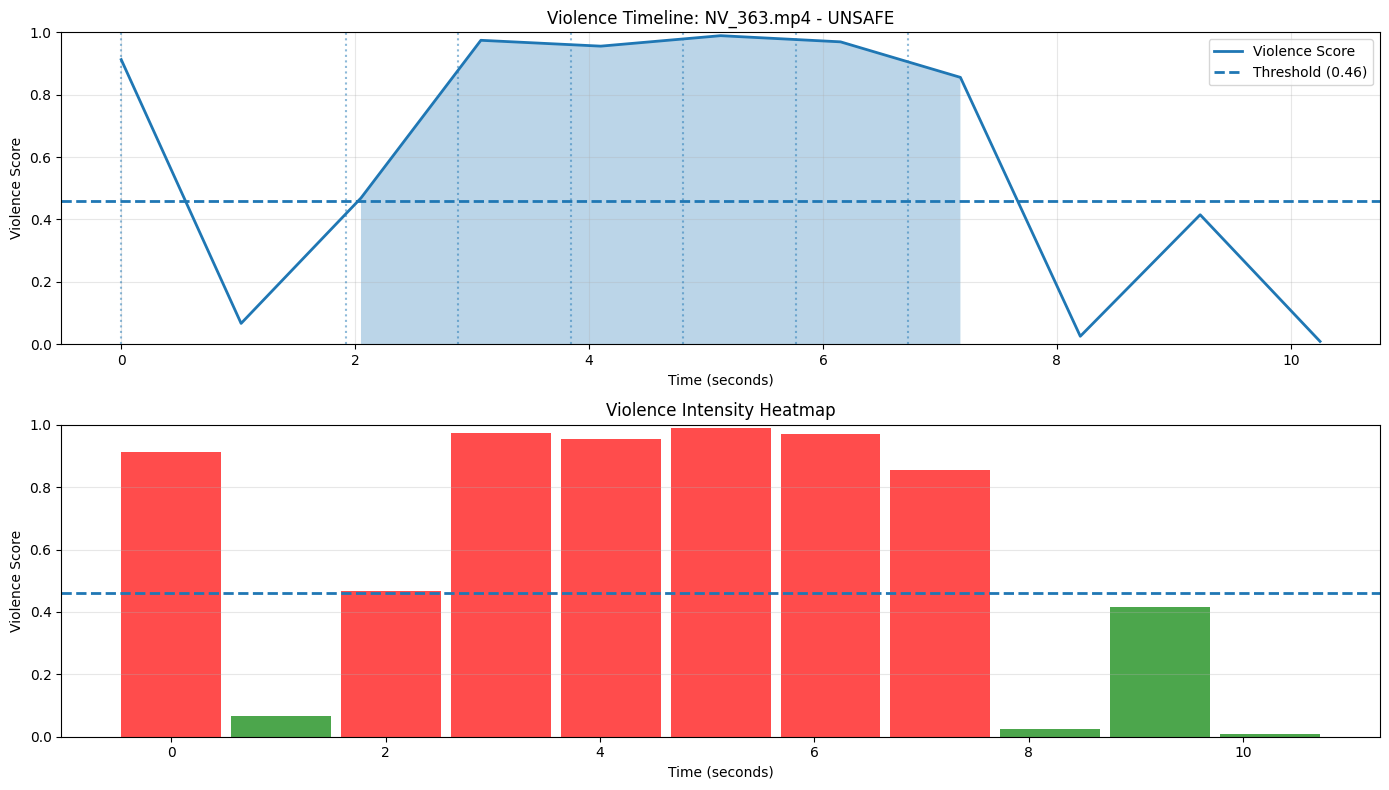

COMPREHENSIVE ANALYSIS: NV_170.mp4

STAGE 1: Quick Scan (Frame-by-Frame)
Overall: 56.3% - UNSAFE
Violent Moments: 3

STAGE 2: Contextual Analysis (16-Frame Sequence)
Overall: 36.9% - SAFE

FINAL VERDICT
Quick Scan: 56.3% - UNSAFE
Contextual: 36.9% - SAFE

FINAL: SAFE
Confidence: MEDIUM
Reasoning: Contextual analysis shows sports/action scene, not actual violence

Violent Timestamps:
• 0:00:00 (79.8%)
• 0:00:01 (48.6%)
• 0:00:04 (88.7%)

Timeline saved: /content/RLVSD/real life violence situations/Real Life Violence Dataset/NonViolence/NV_170_comprehensive_timeline.png


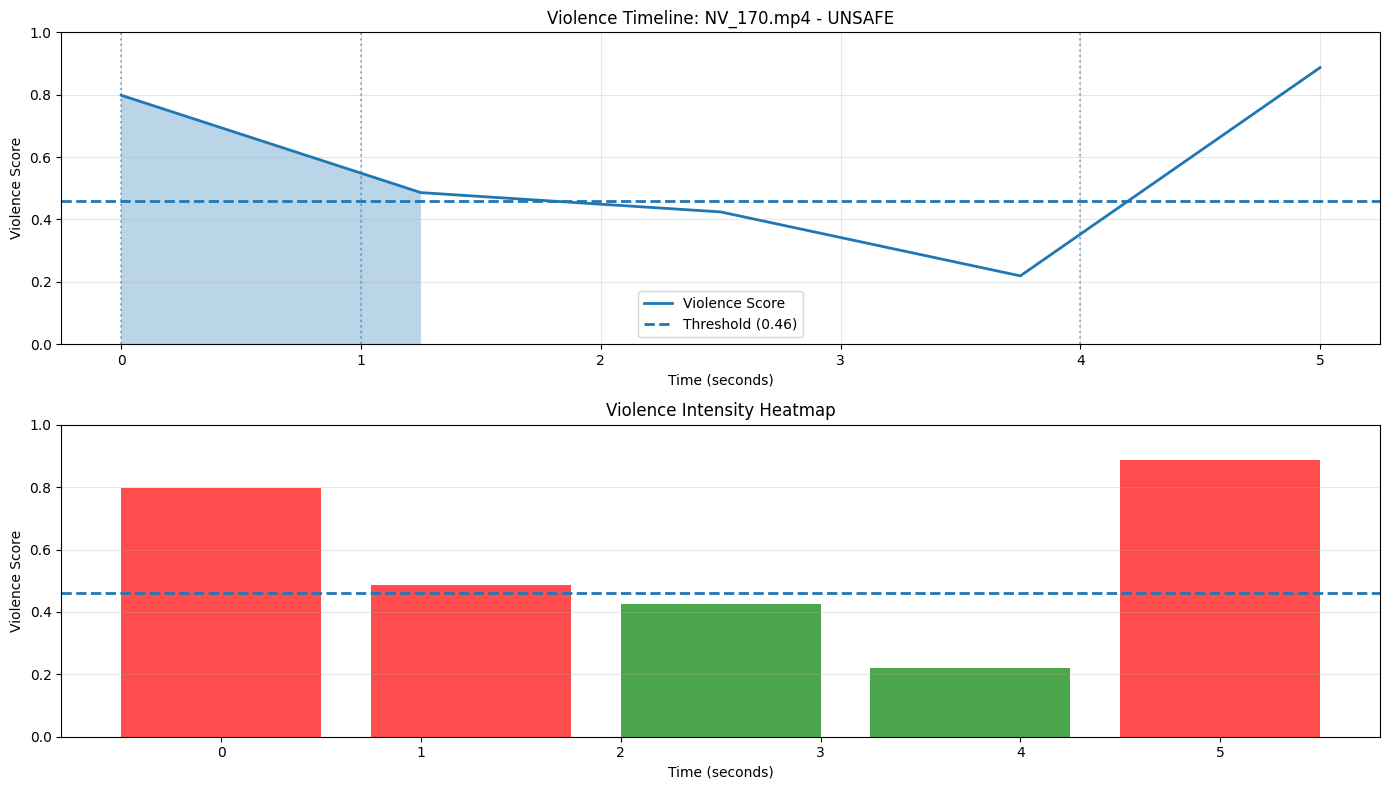


ALL TESTS COMPLETE

Analyzed 3 videos
Generated timeline visualizations
Exported JSON results

Timestamp detection system ready for production!


In [ ]:
# ============================
# COMPLETE VIOLENCE TIMESTAMP DETECTION SYSTEM
# Single Cell - Production Ready
# ============================

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from datetime import timedelta
import json

# ----------------------------
# LOAD MODEL
# ----------------------------
print("Loading model...")
model = load_model('final_violence_model.keras')
print("Model loaded\n")

# ----------------------------
# CONFIG
# ----------------------------
THRESHOLD = 0.46
IMG_SIZE = 64
SEQUENCE_LENGTH = 16

# ----------------------------
# HELPER: FRAME EXTRACTION
# ----------------------------
def frames_extraction(video_path, sequence_length=16, img_size=64):
    """Extract frames from video for sequence-based analysis"""
    frames = []
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(total // sequence_length, 1)
    for i in range(sequence_length):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frames.append(frame / 255.0)
    cap.release()
    while len(frames) < sequence_length:
        frames.append(np.zeros((img_size, img_size, 3)))
    return frames

# ----------------------------
# METHOD 1: QUICK SCAN (FRAME-LEVEL)
# ----------------------------
def detect_violence_timestamps(video_path, sample_rate=1.0, threshold=0.46):
    """
    Quick scan: Frame-by-frame detection with timestamps
    Fast but may flag sports/action as violent
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    frame_interval = int(fps * sample_rate)
    violent_segments = []
    all_scores = []

    for frame_num in range(0, total_frames, frame_interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if not ret:
            break

        frame_resized = cv2.resize(frame, (IMG_SIZE, IMG_SIZE)) / 255.0
        sequence = np.array([[frame_resized] * SEQUENCE_LENGTH])
        score = model.predict(sequence, verbose=0)[0][1]
        all_scores.append(float(score))

        if score > threshold:
            timestamp_seconds = frame_num / fps
            violent_segments.append({
                'timestamp_seconds': timestamp_seconds,
                'timestamp': str(timedelta(seconds=int(timestamp_seconds))),
                'frame_number': frame_num,
                'violence_score': float(score),
                'confidence': float(score * 100)
            })

    cap.release()

    overall_score = np.mean(all_scores) if all_scores else 0
    violent_duration = len(violent_segments) * sample_rate
    is_safe = overall_score < threshold

    return {
        'violent_segments': violent_segments,
        'overall_score': float(overall_score),
        'is_safe': bool(is_safe),
        'verdict': 'SAFE' if is_safe else 'UNSAFE',
        'total_duration': duration,
        'violent_duration': violent_duration,
        'violence_percentage': (violent_duration / duration * 100) if duration > 0 else 0,
        'num_violent_moments': len(violent_segments),
        'all_scores': all_scores
    }

# ----------------------------
# METHOD 2: ACCURATE ANALYSIS (SEQUENCE-BASED)
# ----------------------------
def analyze_video_sequence(video_path, threshold=0.46):
    """
    Accurate analysis: Full 16-frame sequence (like training)
    Better context understanding, distinguishes sports from violence
    """
    frames = frames_extraction(video_path)
    frames_array = np.array([frames])
    prediction = model.predict(frames_array, verbose=0)

    violence_score = float(prediction[0][1])
    is_safe = violence_score < threshold

    return {
        'violence_score': violence_score,
        'is_safe': bool(is_safe),
        'verdict': 'SAFE' if is_safe else 'UNSAFE',
        'confidence': float(max(prediction[0]) * 100)
    }

# ----------------------------
# COMPREHENSIVE DETECTION (BOTH METHODS)
# ----------------------------
def comprehensive_violence_detection(video_path):
    """
    Two-stage detection combining speed and accuracy
    """
    print("="*70)
    print(f"COMPREHENSIVE ANALYSIS: {video_path.split('/')[-1]}")
    print("="*70)

    print("\nSTAGE 1: Quick Scan (Frame-by-Frame)")
    quick_result = detect_violence_timestamps(video_path, sample_rate=1.0)
    print(f"Overall: {quick_result['overall_score']*100:.1f}% - {quick_result['verdict']}")
    print(f"Violent Moments: {quick_result['num_violent_moments']}")

    print("\nSTAGE 2: Contextual Analysis (16-Frame Sequence)")
    accurate_result = analyze_video_sequence(video_path)
    print(f"Overall: {accurate_result['violence_score']*100:.1f}% - {accurate_result['verdict']}")

    print("\n" + "="*70)
    print("FINAL VERDICT")
    print("="*70)

    if quick_result['verdict'] == accurate_result['verdict']:
        final_verdict = accurate_result['verdict']
        confidence = "HIGH"
        reasoning = "Both methods agree"
    elif accurate_result['is_safe'] and not quick_result['is_safe']:
        final_verdict = 'SAFE'
        confidence = "MEDIUM"
        reasoning = "Contextual analysis shows sports/action scene, not actual violence"
    elif not accurate_result['is_safe'] and quick_result['is_safe']:
        final_verdict = 'UNSAFE'
        confidence = "MEDIUM"
        reasoning = "Sequence analysis detects sustained violence patterns"
    else:
        final_verdict = accurate_result['verdict']
        confidence = "HIGH"
        reasoning = "Contextual analysis (more reliable)"

    print(f"Quick Scan: {quick_result['overall_score']*100:.1f}% - {quick_result['verdict']}")
    print(f"Contextual: {accurate_result['violence_score']*100:.1f}% - {accurate_result['verdict']}")

    print(f"\nFINAL: {final_verdict}")
    print(f"Confidence: {confidence}")
    print(f"Reasoning: {reasoning}")

    if quick_result['num_violent_moments'] > 0:
        print("\nViolent Timestamps:")
        for seg in quick_result['violent_segments'][:5]:
            print(f"• {seg['timestamp']} ({seg['confidence']:.1f}%)")
        if len(quick_result['violent_segments']) > 5:
            print(f"... and {len(quick_result['violent_segments'])-5} more")

    print("="*70 + "\n")

    return {
        'final_verdict': final_verdict,
        'confidence': confidence,
        'reasoning': reasoning,
        'quick_scan': quick_result,
        'contextual_analysis': accurate_result
    }

# ----------------------------
# VISUALIZATION
# ----------------------------
def visualize_violence_timeline(result, video_name, save_path=None):
    """Create timeline visualization"""
    scores = result['all_scores']
    duration = result['total_duration']
    threshold = THRESHOLD

    time_points = np.linspace(0, duration, len(scores))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    ax1.plot(time_points, scores, linewidth=2, label='Violence Score')
    ax1.axhline(y=threshold, linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    ax1.fill_between(time_points, 0, scores, where=np.array(scores) > threshold, alpha=0.3)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Violence Score')
    ax1.set_title(f'Violence Timeline: {video_name} - {result["verdict"]}')
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    for seg in result['violent_segments']:
        ax1.axvline(x=seg['timestamp_seconds'], alpha=0.5, linestyle=':')

    colors = ['red' if s > threshold else 'green' for s in scores]
    ax2.bar(time_points, scores, width=duration/len(scores), color=colors, alpha=0.7)
    ax2.axhline(y=threshold, linestyle='--', linewidth=2)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Violence Score')
    ax2.set_title('Violence Intensity Heatmap')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Timeline saved: {save_path}")

    plt.show()

# ----------------------------
# EXPORT TO JSON
# ----------------------------
def export_results_json(result, output_path):
    """Export results to JSON"""
    export_data = {
        'final_verdict': result['final_verdict'],
        'confidence': result['confidence'],
        'reasoning': result['reasoning'],
        'quick_scan': result['quick_scan'],
        'contextual_analysis': result['contextual_analysis']
    }

    with open(output_path, 'w') as f:
        json.dump(export_data, f, indent=2)

    print(f"Results exported to: {output_path}")

# ============================
# TEST SUITE
# ============================

print("\n" + "="*70)
print("COMPREHENSIVE VIOLENCE DETECTION TEST")
print("="*70 + "\n")

test_videos = [
    '/content/RLVSD/real life violence situations/Real Life Violence Dataset/Violence/V_838.mp4',
    '/content/RLVSD/real life violence situations/Real Life Violence Dataset/NonViolence/NV_363.mp4',
    '/content/RLVSD/real life violence situations/Real Life Violence Dataset/NonViolence/NV_170.mp4',
]

results = []

for video_path in test_videos:
    result = comprehensive_violence_detection(video_path)
    results.append(result)

    video_name = video_path.split('/')[-1]
    save_path = video_path.replace('.mp4', '_comprehensive_timeline.png')
    visualize_violence_timeline(result['quick_scan'], video_name, save_path)

    if len(results) == 1:
        export_results_json(result, 'comprehensive_detection_results.json')

print("\n" + "="*70)
print("ALL TESTS COMPLETE")
print("="*70)
print(f"\nAnalyzed {len(test_videos)} videos")
print("Generated timeline visualizations")
print("Exported JSON results")
print("\nTimestamp detection system ready for production!")
